# CSC301 - HHI Calculation
## Authors: Guransh, Raunak

Task Summary:

This script analyzes market concentration using the Herfindahl-Hirschman Index (HHI), which measures how dominant a few companies are in a market. It loads stock market data, calculates daily HHI based on market share, and optionally normalizes it. It also computes a 30-day rolling average HHI to smooth trends over time. The results include summary stats like mean, median, and max HHI, plus the number of companies in the market each day. If enabled, it generates visualizations for daily and rolling HHI, along with the number of companies over time. The final output helps assess whether a market is highly concentrated, moderately concentrated, or unconcentrated.

In [2]:
import polars as pl

# Read the Parquet file using Polars
df = pl.read_parquet('./gliese_quant_crsp_common_stock_adr_2019_2022.parquet')

# Display the first few rows
print(df.head())

shape: (5, 26)
┌────────┬────────┬────────┬──────────┬───┬───────────┬───────────┬───────────┬────────┐
│ permno ┆ permco ┆ ticker ┆ cusip    ┆ … ┆ open      ┆ high      ┆ low       ┆ close  │
│ ---    ┆ ---    ┆ ---    ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---    │
│ i64    ┆ i64    ┆ str    ┆ str      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64    │
╞════════╪════════╪════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪════════╡
│ 10026  ┆ 7976   ┆ JJSF   ┆ 46603210 ┆ … ┆ 143.42    ┆ 144.03999 ┆ 139.12    ┆ 141.0  │
│ 10026  ┆ 7976   ┆ JJSF   ┆ 46603210 ┆ … ┆ 140.60001 ┆ 145.91    ┆ 140.27    ┆ 143.02 │
│ 10026  ┆ 7976   ┆ JJSF   ┆ 46603210 ┆ … ┆ 144.19    ┆ 147.36501 ┆ 143.16479 ┆ 144.84 │
│ 10026  ┆ 7976   ┆ JJSF   ┆ 46603210 ┆ … ┆ 144.37    ┆ 147.87    ┆ 142.83    ┆ 145.41 │
│ 10026  ┆ 7976   ┆ JJSF   ┆ 46603210 ┆ … ┆ 146.14999 ┆ 149.30231 ┆ 145.5     ┆ 148.7  │
└────────┴────────┴────────┴──────────┴───┴───────────┴───────────┴───────────┴────────┘


In [3]:
df.columns

['permno',
 'permco',
 'ticker',
 'cusip',
 'shrout',
 'date',
 'ret',
 'retx',
 'openprc',
 'askhi',
 'bidlo',
 'prc',
 'vol',
 'cfacshr',
 'cfacpr',
 'namedt',
 'nameendt',
 'shrcd',
 'exchcd',
 'market_cap',
 'shares_outstanding',
 'volume',
 'open',
 'high',
 'low',
 'close']

In [4]:
import polars as pl  # Polars is a fast DataFrame library with parallel processing capabilities
import numpy as np  # NumPy for efficient numerical operations
import matplotlib.pyplot as plt  # For visualization
import seaborn as sns  # For enhanced visualization styling
from datetime import datetime, timedelta  # For date handling and manipulation

# Function to calculate traditional Herfindahl-Hirschman Index (HHI)
# HHI measures market concentration based on market shares of companies
def calculate_traditional_hhi(market_shares, normalize=True):
    # Square each market share and sum them
    # HHI ranges from 1/N (equal distribution) to 1 (monopoly)
    hhi = np.sum(market_shares ** 2)

    # Normalize HHI to range from 0 to 1 if requested
    if normalize and len(market_shares) > 1:
        n = len(market_shares)
        # Normalization formula adjusts for the number of companies
        hhi = (hhi - 1/n) / (1 - 1/n)

    return hhi

# Function to compute HHI for each date in the dataset
def calculate_daily_hhi(df, market_cap_column='market_cap', date_column='date',
                        company_column='permco', normalize=True):
    # Ensure we have valid data
    df = df.filter(pl.col(market_cap_column).is_not_null())

    # Sort data by date for efficient processing
    df = df.sort(date_column)

    # Get all unique dates in the dataset
    dates = df.select(pl.col(date_column).unique()).to_series().to_list()
    dates.sort()

    hhi_values = []

    # Process each date separately
    for current_date in dates:
        # Filter data for the current date
        daily_data = df.filter(pl.col(date_column) == current_date)

        if len(daily_data) > 0:
            # Group by company identifier to aggregate market caps
            # Some companies may have multiple stocks (permno) but same permco
            company_data = daily_data.group_by(company_column).agg(
                pl.col(market_cap_column).sum().alias('company_market_cap')
            )

            # Calculate total market cap for the day
            total_market_cap = company_data.select(pl.sum('company_market_cap')).item()

            if total_market_cap > 0:
                # Calculate market share for each company
                market_shares = (company_data.select('company_market_cap').to_numpy().flatten()
                                / total_market_cap)

                # Calculate HHI for this date
                hhi = calculate_traditional_hhi(market_shares, normalize=normalize)

                # Store the result with the date
                hhi_values.append((current_date, hhi, len(company_data)))

    # Create a DataFrame with the results
    return pl.DataFrame({
        date_column: [x[0] for x in hhi_values],
        'hhi': [x[1] for x in hhi_values],
        'company_count': [x[2] for x in hhi_values]
    }) if hhi_values else pl.DataFrame({date_column: [], 'hhi': [], 'company_count': []})

In [5]:
# Function to calculate rolling average HHI over a specified window
def calculate_rolling_hhi(hhi_df, date_column='date', hhi_column='hhi', window_days=30):
    # Sort by date to ensure proper window calculation
    hhi_df = hhi_df.sort(date_column)

    # Extract dates and HHI values
    dates = hhi_df.select(pl.col(date_column)).to_series().to_list()
    hhi_values = hhi_df.select(pl.col(hhi_column)).to_series().to_list()

    rolling_values = []

    # Calculate rolling average for each date
    for i, current_date in enumerate(dates):
        if not isinstance(current_date, datetime):
            current_date = datetime.strptime(str(current_date), "%Y-%m-%d")

        # Define start date for the rolling window
        start_date = current_date - timedelta(days=window_days)

        # Find indices within the window
        window_indices = [j for j, date in enumerate(dates) if
                         (not isinstance(date, datetime) and
                          datetime.strptime(str(date), "%Y-%m-%d") >= start_date and
                          datetime.strptime(str(date), "%Y-%m-%d") <= current_date) or
                         (isinstance(date, datetime) and date >= start_date and date <= current_date)]

        # Calculate average HHI for the window
        if window_indices:
            window_hhi = [hhi_values[j] for j in window_indices]
            rolling_avg = np.mean(window_hhi)
            rolling_values.append((current_date, rolling_avg))

    # Create DataFrame with rolling averages
    return pl.DataFrame({
        date_column: [x[0] for x in rolling_values],
        'rolling_hhi': [x[1] for x in rolling_values]
    }) if rolling_values else pl.DataFrame({date_column: [], 'rolling_hhi': []})

In [6]:
# Function to visualize HHI trends
def visualize_hhi(hhi_df, rolling_hhi_df=None, date_column='date', hhi_column='hhi',
                 rolling_column='rolling_hhi', title="Market Concentration (HHI) Over Time"):
    # Create a new figure with appropriate size
    plt.figure(figsize=(12, 6))

    # Use seaborn's styling for better visuals
    sns.set_style('whitegrid')

    # Extract dates and HHI values
    dates = hhi_df.select(pl.col(date_column)).to_series().to_list()
    hhi_values = hhi_df.select(pl.col(hhi_column)).to_series().to_list()

    # Plot daily HHI
    plt.plot(dates, hhi_values, linewidth=1, alpha=0.6, label='Daily HHI', color='steelblue')

    # Plot rolling average if provided
    if rolling_hhi_df is not None and len(rolling_hhi_df) > 0:
        rolling_dates = rolling_hhi_df.select(pl.col(date_column)).to_series().to_list()
        rolling_values = rolling_hhi_df.select(pl.col(rolling_column)).to_series().to_list()
        plt.plot(rolling_dates, rolling_values, linewidth=2, label=f'{rolling_column} (30-day)', color='darkblue')

    # Add reference lines for DOJ HHI thresholds
    plt.axhline(y=0.25, color='r', linestyle='--', alpha=0.5, label='Highly Concentrated (0.25)')
    plt.axhline(y=0.15, color='y', linestyle='--', alpha=0.5, label='Moderately Concentrated (0.15)')
    plt.axhline(y=0.10, color='g', linestyle='--', alpha=0.5, label='Unconcentrated (0.10)')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('HHI Value')
    plt.title(title)
    plt.legend()

    # Display the plot
    plt.show()

In [7]:
# Main function that orchestrates the entire analysis
def analyze_market_concentration(df, market_cap_column='market_cap', date_column='date',
                                company_column='permco', normalize=True, visualize=True,
                                rolling_window=30):
    # Ensure date column is in the correct format
    df = df.with_columns(pl.col(date_column).cast(pl.Date))

    # Calculate HHI for each day
    print("Calculating daily HHI values...")
    hhi_df = calculate_daily_hhi(df, market_cap_column, date_column, company_column, normalize)

    # Calculate rolling average HHI
    print("Calculating rolling average HHI...")
    rolling_hhi_df = calculate_rolling_hhi(hhi_df, date_column, 'hhi', rolling_window)

    # Extract HHI values for summary statistics
    hhi_values = hhi_df.select(pl.col('hhi')).to_numpy().flatten()

    # Compile results
    results = {
        'hhi_df': hhi_df,
        'rolling_hhi_df': rolling_hhi_df,
        'mean_hhi': float(np.mean(hhi_values)) if len(hhi_values) > 0 else None,
        'median_hhi': float(np.median(hhi_values)) if len(hhi_values) > 0 else None,
        'max_hhi': float(np.max(hhi_values)) if len(hhi_values) > 0 else None,
        'min_hhi': float(np.min(hhi_values)) if len(hhi_values) > 0 else None,
        'latest_hhi': float(hhi_values[-1]) if len(hhi_values) > 0 else None
    }

    # Display summary statistics
    print("\nMarket Concentration Statistics:")
    print(f"Mean HHI: {results['mean_hhi']:.4f}")
    print(f"Median HHI: {results['median_hhi']:.4f}")
    print(f"Max HHI: {results['max_hhi']:.4f}")
    print(f"Min HHI: {results['min_hhi']:.4f}")
    print(f"Latest HHI: {results['latest_hhi']:.4f}")

    # Add interpretation
    mean_hhi = results['mean_hhi']
    if mean_hhi > 0.25:
        concentration_level = "Highly concentrated"
    elif mean_hhi > 0.15:
        concentration_level = "Moderately concentrated"
    else:
        concentration_level = "Unconcentrated"
    print(f"\nInterpretation: Market is {concentration_level} (Mean HHI: {mean_hhi:.4f})")

    # Add company count statistics
    company_counts = hhi_df.select(pl.col('company_count')).to_numpy().flatten()
    if len(company_counts) > 0:
        print(f"\nNumber of Companies:")
        print(f"Average: {np.mean(company_counts):.1f}")
        print(f"Maximum: {np.max(company_counts)}")
        print(f"Minimum: {np.min(company_counts)}")

    # Visualize results if requested and data is available
    if visualize and len(hhi_df) > 0:
        visualize_hhi(hhi_df, rolling_hhi_df, date_column, 'hhi')

    return results

Loading data...

Available columns:
['permno', 'permco', 'ticker', 'cusip', 'shrout', 'date', 'ret', 'retx', 'openprc', 'askhi', 'bidlo', 'prc', 'vol', 'cfacshr', 'cfacpr', 'namedt', 'nameendt', 'shrcd', 'exchcd', 'market_cap', 'shares_outstanding', 'volume', 'open', 'high', 'low', 'close']

Data sample:
shape: (3, 26)
┌────────┬────────┬────────┬──────────┬───┬───────────┬───────────┬───────────┬────────┐
│ permno ┆ permco ┆ ticker ┆ cusip    ┆ … ┆ open      ┆ high      ┆ low       ┆ close  │
│ ---    ┆ ---    ┆ ---    ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---    │
│ i64    ┆ i64    ┆ str    ┆ str      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64    │
╞════════╪════════╪════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪════════╡
│ 10026  ┆ 7976   ┆ JJSF   ┆ 46603210 ┆ … ┆ 143.42    ┆ 144.03999 ┆ 139.12    ┆ 141.0  │
│ 10026  ┆ 7976   ┆ JJSF   ┆ 46603210 ┆ … ┆ 140.60001 ┆ 145.91    ┆ 140.27    ┆ 143.02 │
│ 10026  ┆ 7976   ┆ JJSF   ┆ 46603210 ┆ … ┆ 144.19    ┆ 

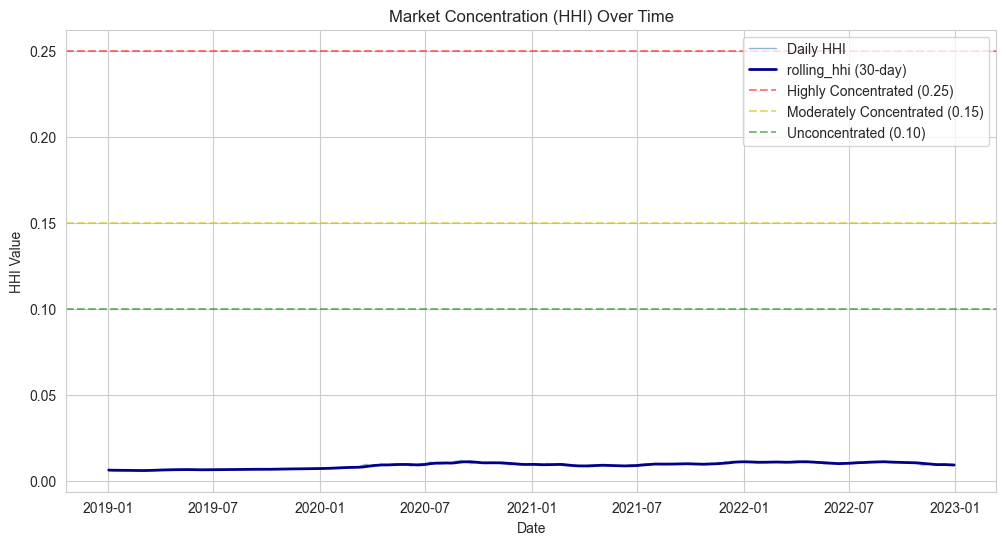

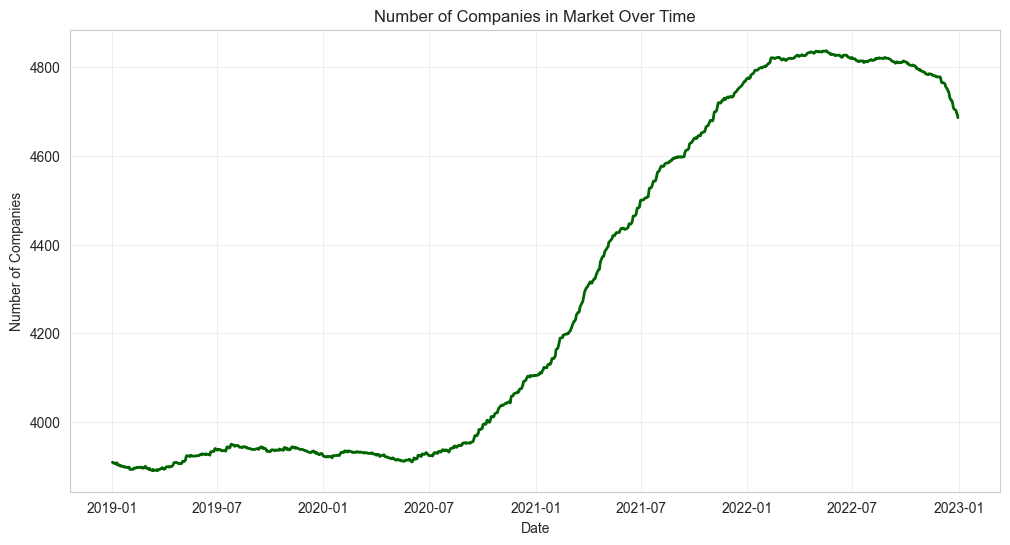

In [9]:
# Path to the data file
parquet_file = './gliese_quant_crsp_common_stock_adr_2019_2022.parquet'

# Load data using Polars' efficient parquet reader
print("Loading data...")
df = pl.read_parquet(parquet_file)

# Print available columns for confirmation
print("\nAvailable columns:")
print(df.columns)

# Print data sample
print("\nData sample:")
print(df.head(3))

# Run the analysis
print("\nAnalyzing market concentration...")
results = analyze_market_concentration(df, market_cap_column='market_cap', date_column='date')

# Additional visualization: Tracking number of companies over time
if len(results['hhi_df']) > 0:
    plt.figure(figsize=(12, 6))
    dates = results['hhi_df'].select(pl.col('date')).to_series().to_list()
    company_counts = results['hhi_df'].select(pl.col('company_count')).to_series().to_list()
    plt.plot(dates, company_counts, linewidth=2, color='darkgreen')
    plt.xlabel('Date')
    plt.ylabel('Number of Companies')
    plt.title('Number of Companies in Market Over Time')
    plt.grid(True, alpha=0.3)
    plt.show()